# Keras version of VGG

We'll train VGG with the CIFAR-10 dataset.

The Visual Geometry Group (VGG) at the University of Oxford created this model for the 2014 ImageNet competition: [VGG](https://arxiv.org/pdf/1409.1556.pdf).  They tested several versions of the topology (different depths). Typically, the 16 layer (VGG-16) and 19-layer (VGG-19) toplogies are used.

Keypoints:
+ VGG uses all 3x3 filters
+ Receptive field explanation
+ 1x1 convolutions - Network in Network
+ Data augmentation with random cropping, flipping, color shifting

In [1]:
import keras
from keras.datasets import cifar10
from keras.layers   import Dense, Dropout, Flatten
from keras.layers   import Input, Conv2D, MaxPooling2D
from keras.models   import Model
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


# Common terms

+ SGD : Stochastic gradient descent. The usual way to train a neural network. The "weights" or "parameters" of the network are updated bit by bit in order to minimize some global function ("cost" or "loss")
+ "Cost" or " Loss" - A function we wish the network to minimize. This is typically some distance measure of how far the network's prediction is from the actual value (i.e. the error).
+ Epoch = A single pass through the entire training set. SGD involves mulitple passes through the training dataset. 
+ Batch = How many samples of the training dataset are used to create an update to the weights of the network during SGD. If the batch is 1, then the weights are updated after every forward pass (truly stochastic descent). If the batch is the size of the dataset then the weights are updated based on the sum of the gradients for the entire training set (non-stochastic or just gradient descent). We usually use batch or mini-batch gradient descent.

In [2]:
batch_size  = 128
num_classes = 10
epochs      = 8

# CIFAR-10

[CIFAR](https://www.cs.toronto.edu/~kriz/cifar.html) is a subset of the "tiny images" dataset that includes 80 million images.

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. 

The 10 classes are:
+ airplane
+ automobile
+ bird
+ cat
+ deer
+ dog
+ frog
+ horse
+ ship
+ truck

Tensor size = NHWC = Batch size x 32 x 32 x 3

In [3]:
# input image dimensions
img_rows, img_cols, n_channels = 32, 32, 3
input_shape = (img_rows, img_cols, n_channels)

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Scale images between -1 and 1 with mean of 0
x_train_norm = x_train - x_train.mean()
x_test_norm  = x_test  - x_test.mean()

x_train_norm /= x_train_norm.max()  
x_test_norm  /= x_test_norm.max()    

In [5]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

('x_train shape:', (50000, 32, 32, 3))
(50000, 'train samples')
(10000, 'test samples')


# One Hot Encoding

For multi-class problems we always one-hot encode the output variable. There are 10 classes (numbers 0-9). The label for 7 would be 0000001000. The label for 0 would be 1000000000. The label for 3 would be 0010000000. This allows us to use the cost function of [multi-class entropy](https://en.wikipedia.org/wiki/Cross_entropy) which will maximize the margin between classes.

In [6]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# VGG-16

![VGG diagram](https://i.stack.imgur.com/3R0Kd.png)

Above is VGG-16. In the original specification, the last 3 convolutional blocks use a 1x1 convolution as the last operation. Again, since we only have a 32x32 input image, we'll won't do as many layers (otherwise we would quickly run out of pixels).

In [7]:
inputs = Input(input_shape, name='Images')

# Block 1
conv1 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
conv2 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(conv1)

max2 = MaxPooling2D(pool_size=(2,2))(conv2)

# Block 2
conv3 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max2)
conv4 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(conv3)

max3 = MaxPooling2D(pool_size=(2,2))(conv4)

# Block 3
conv5 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(max3)
conv6 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(conv5)
conv7 = Conv2D(filters=256, kernel_size=(1,1), activation='relu', padding='same')(conv6)

max4 = MaxPooling2D(pool_size=(2,2))(conv7)

# Block 4
conv8 = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(max4)
conv9 = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(conv8)
conv10 = Conv2D(filters=512, kernel_size=(1,1), activation='relu', padding='same')(conv9)

layer11 = Flatten()(conv10)

layer12 = Dense(4096, activation='relu')(layer11)

layer13 = Dropout(0.5)(layer12)

layer14 = Dense(4096, activation='relu')(layer13)

layer15 = Dense(num_classes, activation='softmax')(layer14)

model = Model(inputs=[inputs], outputs=[layer15])

# TensorBoard

TensorBoard is an essential tool to monitor our model and the training.  Keras/TF will write a log after every epoch of the model and the current training metrics. All you need to do is type at the command line:

tensorboard --logdir='./logs'

And then open the browser to http://localhost:6006


In [8]:
tb_log = keras.callbacks.TensorBoard(log_dir='./logs', # This is where the log files will go
                                     histogram_freq=10, 
                                     batch_size=batch_size, 
                                     write_graph=True, 
                                     write_grads=True, 
                                     write_images=True)


In [9]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01),
              metrics=['accuracy'])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Images (InputLayer)          (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
__________

# Data augmentation

VGG used data augmentation to "add" more training data and make the model more invariant to rotation and position. Most frameworks have online data augmentation built in. In Keras the [ImageDataGenerator](https://keras.io/preprocessing/image/) creates an iterator that randomly applies flips, rotations, crops, and scalings to the images when each batch is loaded into SGD.

In [11]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)


In [12]:
# fits the model on batches with real-time data augmentation:
history = model.fit_generator(datagen.flow(x_train_norm, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train_norm) / batch_size, epochs=epochs, 
                    validation_data=(x_test_norm, y_test), callbacks=[tb_log])

Epoch 1/8
390/390 [==============================] - 349s 895ms/step - loss: 1.8599 - acc: 0.2823 - val_loss: 1.5344 - val_acc: 0.4125
Epoch 2/8
390/390 [==============================] - 131s 336ms/step - loss: 1.5027 - acc: 0.4329 - val_loss: 1.3362 - val_acc: 0.4977
Epoch 3/8
390/390 [==============================] - 131s 335ms/step - loss: 1.3355 - acc: 0.5086 - val_loss: 1.1721 - val_acc: 0.5705
Epoch 4/8
390/390 [==============================] - 132s 338ms/step - loss: 1.2405 - acc: 0.5438 - val_loss: 1.1283 - val_acc: 0.5829
Epoch 5/8
390/390 [==============================] - 132s 339ms/step - loss: 1.1689 - acc: 0.5755 - val_loss: 1.0950 - val_acc: 0.6045
Epoch 6/8
390/390 [==============================] - 127s 326ms/step - loss: 1.1293 - acc: 0.5890 - val_loss: 1.0139 - val_acc: 0.6318
Epoch 7/8
390/390 [==============================] - 127s 326ms/step - loss: 1.0948 - acc: 0.6054 - val_loss: 0.9753 - val_acc: 0.6452
Epoch 8/8
390/390 [==============================] - 12

In [13]:
score = model.evaluate(x_test_norm, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 7s 736us/step
('Test loss:', 0.99686348571777339)
('Test accuracy:', 0.64029999999999998)


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# Loss curves

It's always a good idea to look at the loss curves. They can tell you if your model is indeed "learning" and can point out when it over-fits the training set. TensorBoard is the better way to monitor this, but it can be done also manually with matplotlib.

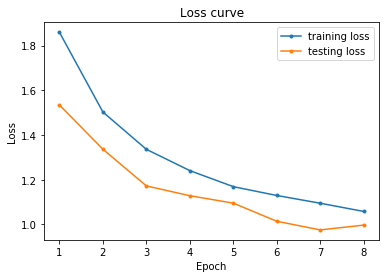

In [15]:
plt.plot(range(1,epochs+1),history.history['loss'], '.-',
         range(1,epochs+1),history.history['val_loss'], '.-');
plt.legend(['training loss', 'testing loss'])
plt.title('Loss curve');
plt.xlabel('Epoch');
plt.ylabel('Loss');

# Predictions

Now let's use the model to predict the test set images.

![cifar10](https://cdn-images-1.medium.com/max/1600/1*6XQqOifwnmplS22zCRRVaw.png)

In [19]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [20]:
all_predictions = model.predict(x_test_norm).argmax(axis=1)
print(all_predictions)

[3 1 8 ..., 5 3 7]


In [21]:
import numpy as np

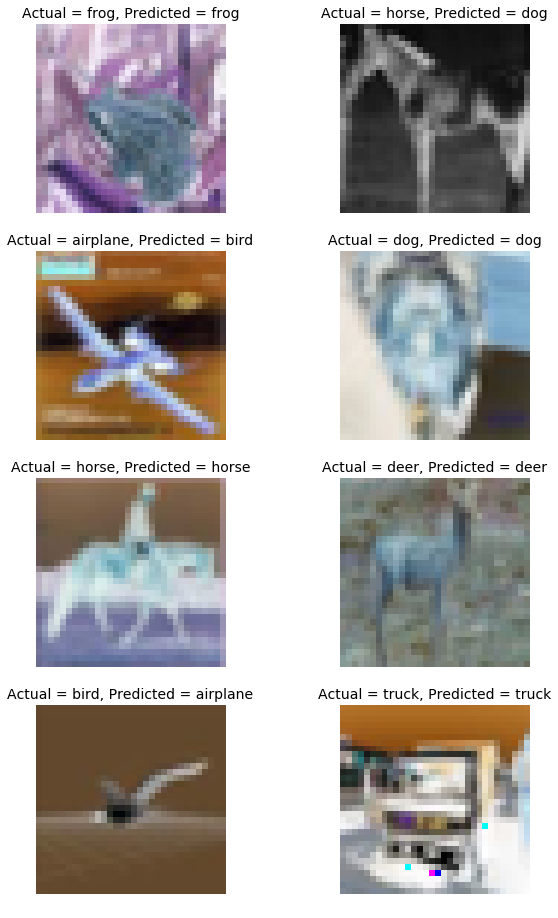

In [24]:
samples = [4, 83, 298, 1045, 3751, 5555, 7112, 8953] # Just print out some random examples from the test set

plt.subplots(len(samples)//2, 2, figsize=(10, 16))

for i, n in enumerate(samples):

    img_norm = np.expand_dims(x_test_norm[n, :, :, :], 0) # Numpy collapses the singleton dimension
    img = np.expand_dims(x_test[n, :, :, :], 0) # Numpy collapses the singleton dimension
    
    plt.subplot(len(samples)//2, 2, i+1)
    plt.imshow(img.squeeze());
    plt.axis('off')

    label = y_test[n].argmax()   
    predicted_label = model.predict(img_norm).argmax()   # Predict for just one image

    plt.title('Actual = {}, Predicted = {}'.format(labels[label], labels[predicted_label]), fontsize=14);